In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import time
import datetime
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from operator import attrgetter

import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Membaca data dan menghapus kolom Unnamed: 0
df = pd.read_csv('./Datasets/df_clean.csv')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df.drop(columns={'Unnamed: 0'}, inplace=True)
df.sort_values(by='order_purchase_timestamp', inplace=True)
df.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,price,freight_value,product_category_name_english,customer_lat,customer_lng,review_score,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,order_date_day,order_date_day_name,order_date_month,order_date_month_name,order_date_year,order_date_monthyear,order_date_hour,revenue
107852,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,14600.0,sao joaquim da barra,SP,1.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,health_beauty,-20.585751,-47.863693,1.0,81810.0,curitiba,PR,81810.0,-25.507014,-49.275963,15.0,Thursday,9.0,September,2016.0,2016-09,12,47.82
107854,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,14600.0,sao joaquim da barra,SP,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,health_beauty,-20.585751,-47.863693,1.0,81810.0,curitiba,PR,81810.0,-25.507014,-49.275963,15.0,Thursday,9.0,September,2016.0,2016-09,12,47.82
107853,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,14600.0,sao joaquim da barra,SP,2.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,health_beauty,-20.585751,-47.863693,1.0,81810.0,curitiba,PR,81810.0,-25.507014,-49.275963,15.0,Thursday,9.0,September,2016.0,2016-09,12,47.82
75763,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,4106.0,sao paulo,SP,1.0,3ae08df6bcbfe23586dd431c40bddbb7,522620dcb18a6b31cd7bdf73665113a9,29.90,15.56,watches_gifts,-23.581451,-46.635029,4.0,85801.0,cascavel,PR,85801.0,-24.959184,-53.462644,3.0,Monday,10.0,October,2016.0,2016-10,9,45.46
110332,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,98280.0,panambi,RS,1.0,fd7fd78fd3cbc1b0a6370a7909c0a629,f09b760d23495ac9a7e00d29b769007c,21.90,17.19,sports_leisure,-28.293541,-53.502238,4.0,15802.0,catanduva,SP,15802.0,-21.143389,-48.995314,3.0,Monday,10.0,October,2016.0,2016-10,16,39.09


In [3]:
time_max = df['order_purchase_timestamp'].max()
# time_max = time_max.strftime("%Y-%m-%d")
# time_max = datetime.strptime(time_max, '%Y-%m-%d')
time_max

Timestamp('2018-08-29 15:00:37')

In [4]:
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: ((time_max + timedelta(days=1)) - x.max()).days,
    'order_id': 'count',
    'price': 'sum',
}).reset_index()

rfm.rename(columns={
    'order_purchase_timestamp': 'recency',
    'order_id': 'frequency',
    'price': 'monetary'
}, inplace=True)


In [5]:
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [43]:
# rfm.to_csv('./Datasets/rfm__.csv')

### Recency Score
- Recency Score = 4, aktif terakhir 1 - 114 hari yang lalu
- Recency Score = 3, aktif terakhir 115 - 219 hari yang lalu
- Recency Score = 2, aktif terakhir 220 - 346 hari yang lalu
- Recency Score = 1, aktif terakhir > 347 hari yang lalu

### Order Frequency Score
- Frequency = 4 (more then top 25% orders)
- Frequency = 3 (quartile 3)
- Frequency = 2 (quartile 2)
- Frequency = 1 (1 order)

### Monetary Score
- Monetary = 4 (quartile 4)
- Monetary = 3 (quartile 3)
- Monetary = 2 (quartile 2)
- Monetary = 1 (quartile 1)

In [7]:
Q1 = np.quantile(rfm.frequency.unique(), 0.25)
Q2 = np.quantile(rfm.frequency.unique(), 0.5)
Q3 = np.quantile(rfm.frequency.unique(), 0.75)
print(Q1, Q2, Q3)

5.5 10.0 14.5


In [8]:
# Membagi menjadi 5 grup untuk recency dan monetary
rfm_quintiles = rfm[['recency', 'monetary']].quantile([0.2, 0.4, 0.6, 0.8])
rfm_quintiles
# # Membagi menjadi 5 grup untuk recency dan monetary
# rfm_quintiles = rfm[['recency', 'monetary']].quantile([0.2, 0.4, 0.6, 0.8])
# rfm_quintiles


,recency,monetary
0.2,92.0,39.9
0.4,177.0,69.9
0.6,268.0,109.9
0.8,382.0,179.9


In [41]:
print(rfm_quintiles.recency)

0.2     92.0
0.4    177.0
0.6    268.0
0.8    382.0
Name: recency, dtype: float64


In [9]:
# Binning Recency dengan quintile
def recency_score(x):
    q1 = rfm_quintiles.loc[0.2, 'recency']
    q2 = rfm_quintiles.loc[0.4, 'recency']
    q3 = rfm_quintiles.loc[0.6, 'recency']
    q4 = rfm_quintiles.loc[0.8, 'recency']
    
    if x <= q1:
        return 5
    elif q1 < x <= q2:
        return 4
    elif q2 < x <= q3:
        return 3
    elif q4 < x <= q4:
        return 2
    else:
        return 1

# Binning Frequency
def frequency_score(x):
    q = np.quantile(rfm.frequency.unique(), [0.2, 0.4, 0.6, 0.8])
    if x <= q[0]:
        return 1
    elif q[0] < x <= q[1]:
        return 2
    elif q[1] < x <= q[2]:
        return 3
    elif q[2] < x <= q[3]:
        return 4
    else:
        return 5
    
# def frequency_and_monetary_score(x, col):
#     q1 = rfm_quintiles.loc[0.2, col]
#     q2 = rfm_quintiles.loc[0.4, col]
#     q3 = rfm_quintiles.loc[0.6, col]
#     q4 = rfm_quintiles.loc[0.8, col]
    
#     if x <= q1:
#         return 1
#     elif q1 < x <= q2:
#         return 2
#     elif q2 < x <= q3:
#         return 3
#     elif q4 < x <= q4:
#         return 4
#     else:
#         return 5

def monetary_score(x, col):
    q1 = rfm_quintiles.loc[0.2, col]
    q2 = rfm_quintiles.loc[0.4, col]
    q3 = rfm_quintiles.loc[0.6, col]
    q4 = rfm_quintiles.loc[0.8, col]
    
    if x <= q1:
        return 1
    elif q1 < x <= q2:
        return 2
    elif q2 < x <= q3:
        return 3
    elif q4 < x <= q4:
        return 4
    else:
        return 5
    
# Membuat kolom RFM Score baru
rfm['R_Score'] = rfm['recency'].apply(lambda x: recency_score(x))
rfm['F_Score'] = rfm['frequency'].apply(lambda x: frequency_score(x))
rfm['M_Score'] = rfm['monetary'].apply(lambda x: monetary_score(x, 'monetary'))

In [46]:
monetary_score('2000', 'monetary')

TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'str'

In [21]:
rfm['RFM_Total_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)



Hasil RFM Score kemudian digabungkan untuk dapat diketahui segmen-segmen sebagai berikut.

|Segmen|RFM Score|Deskripsi
|:----|:----|:----|
|Champions|453, 455, 552, 553, 555|Pelanggan baru saja membeli barang, sering membeli barang dan membelanjakan uang dengan jumlah besar
|Potential Loyalist|451, 452, 551 |Pelanggan baru saja membeli barang dengan frekuensi membeli diatas rata-rata
|Recent Customer|512, 513, 515|Pelanggan baru saja membeli barang, tetapi tidak sering membeli barang
|Promising|411, 412, 413, 415|Pelanggan baru saja membeli barang tetapi tidak berbelanja dalam jumlah besar
|Loyal Customer|351, 352, 353, 355|Pelanggan selalu membeli barang, responsif terhadap promosi
|Needs Attention|-|Recency, Frequency dan Monetary diatas rata-rata, bisa saja tidak baru membeli barang
|About to sleep|311, 312, 313, 315|Recency dan Frequency dibawah rata-rata, akan kehilangan apabila tidak aktif kembali
|At Risk|-|Sudah lama tidak membeli barang dan harus segera diberi promosi agar kembali lagi berbelanja
|Can't Lose Them|151, 152, 153, 155|Pernah belanja sering namun nilai recency kecil
|Hibernating|112, 113, 115|Terakhir membeli sudah lama dan jumlah barang yang dibeli sedikit
|Lost|111|Terakhir membeli sudah lama, barang yang dibeli sedikit dan jumlah yang dibelanjakan sedikit

In [22]:
def segment(x):
    if (x == '453') | (x == '455') | (x == '552') | (x == '553') | (x == '555'):
        return 'Champions'
    elif (x == '451') | (x == '452') | (x == '551'):
        return 'Potential Loyalist'
    elif (x == '512') | (x == '513') | (x == '515'):
        return 'Recent Customer'
    elif (x == '411') | (x == '412') | (x == '413') | (x == '415'):
        return 'Promising'
    elif (x == '351') | (x == '352') | (x == '353') | (x == '355'):
        return 'Loyal Customer'
    elif (x == '311') | (x == '312') | (x == '313') | (x == '315'):
        return 'About to Sleep'
    elif (x == '112') | (x == '113') | (x == '115'):
        return 'Hibernating'
    elif (x == '151') | (x == '152') | (x == '153') | (x == '155'):
        return 'Can\'t Lose Them'
    elif (x == '111'):
        return 'Lost'

In [23]:
rfm['Segment'] = rfm['RFM_Total_Score'].apply(lambda x: segment(x))

In [24]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,R_Score,F_Score,M_Score,RFM_Total_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,5,415,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,Promising
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,Hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111,Lost
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,5,115,Hibernating


In [29]:
x = pd.DataFrame(rfm['Segment'].value_counts())
x

,Segment
Hibernating,29242
About to Sleep,18588
Promising,18557
Recent Customer,14720
Lost,7753
Can't Lose Them,4
Loyal Customer,1
Champions,1


In [37]:
segment = rfm.pivot_table(index='Segment', values='RFM_Total_Score', aggfunc='count').reset_index().sort_values(by='RFM_Total_Score')
segment['RFM Score Percentage'] = round((segment['RFM_Total_Score'] / sum(segment['RFM_Total_Score'])) * 100, 2)

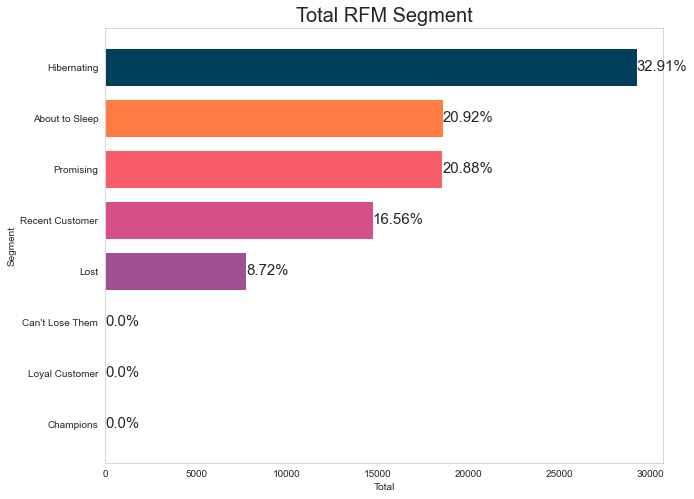

In [39]:
color_list = ['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43']
fig, ax = plt.subplots(figsize=(10, 8))    
width = 0.75
bars = ax.barh(segment['Segment'], segment['RFM_Total_Score'], width, color=color_list)
plt.title('Total RFM Segment', fontsize=20)
plt.xlabel('Total')
plt.ylabel('Segment')      

for i, bar in enumerate(bars):
    val = bar.get_width()
    ax.text(val, bar.get_y() + bar.get_height()/2, 
            '{}%'.format(round(val/sum(segment['RFM_Total_Score']) * 100, 2)),
            va='center',
            ha='left',
            fontsize=15,
#             color=color_list[i]
            
           )
plt.grid(False)
plt.show()

## Kesimpulan

- Pelanggan paling banyak pada perusahaan ini sekitar 32.91% Hibernating, yakni recency kecil dan membeli barang dalam jumlah sedikit
- Tipe pelanggan yang lain ada About to Sleep, Promising, Recent Customer, Lost, Can't Lose Them, Loyal Customer dan Champions
- Jumlah 3 terbawah nilainya sangat kecil
- Kluster pelanggan selanjutnya akan diberikan treatment sebagai berikut.

|Segmen|RFM Score|Treatment
|:----|:----|:----|
|Champions|453, 455, 552, 553, 555|Reward them. Can be early adopters for new products. Will promote your brand.
|Potential Loyalist|451, 452, 551 |Offer membership / loyalty program, recommend other products.
|Recent Customer|512, 513, 515|Provide on-boarding support, give them early success, start building relationship.
|Promising|411, 412, 413, 415|Create brand awareness, offer free trials
|Loyal Customer|351, 352, 353, 355|Upsell higher value products. Ask for reviews. Engage them.
|Needs Attention|-|	Make limited time offers, Recommend based on past purchases. Reactivate them.
|About to sleep|311, 312, 313, 315|Share valuable resources, recommend popular products / renewals at discount, reconnect with them.
|At Risk|-|Send personalized emails to reconnect, offer renewals, provide helpful resources.
|Can't Lose Them|151, 152, 153, 155|Win them back via renewals or newer products, don’t lose them to competition, talk to them.
|Hibernating|112, 113, 115|Offer other relevant products and special discounts. Recreate brand value.
|Lost|111|Revive interest with reach out campaign, ignore otherwise.